In [1]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt

In [2]:
class Agent:
    """
    An Agent class for playing Blackjack using a Monte Carlo method for control.

    Attributes:
        epsilon (float): Exploration rate for the epsilon-greedy policy.
        gamma (float): Discount factor for future rewards.
        sum_space (list): Possible values of the player's hand sum.
        dealer_show_card_space (list): Possible values of the dealer's visible card.
        ace_space (list): Indicates whether the player's hand includes an ace.
        action_space (list): Available actions (0 for stick, 1 for hit).
        Q (dict): Stores the estimated value of each state-action pair.
        pi (dict): Stores the policy probabilities for each action in each state.
        returns (dict): Accumulated returns for each state-action pair.
        states_visited (dict): Tracks visit counts for each state-action during episodes.
        state_space (list): All possible states.
        memory (list): Temporary storage for state, action, and reward per episode.
    """

    def __init__(self, epsilon=0.1, gamma=0.99):
        """
        Initializes the agent with given exploration rate and discount factor,
        and sets up the state space and initial policy.
        """
        self.epsilon = epsilon
        self.gamma = gamma

        self.sum_space = [i for i in range(4, 22)]
        self.dealer_show_card_space = [i for i in range(1, 11)]
        self.ace_space = [False, True]
        self.action_space = [0, 1]

        self.Q = {}
        self.pi = {}
        self.returns = {}
        self.states_visited = {}
        self.state_space = []
        self.memory = []

        self.init_vals()

    def init_vals(self):
        """
        Initializes the Q-values, policy probabilities, and state-related data structures for
        all state-action pairs in the game.
        """
        for total in self.sum_space:
            for card in self.dealer_show_card_space:
                for ace in self.ace_space:
                    self.Q[(total, card, ace)] = {}
                    self.pi[(total, card, ace)] = {}
                    self.returns[(total, card, ace)] = {}
                    self.states_visited[(total, card, ace)] = {}
                    self.state_space.append((total, card, ace))
                    for action in self.action_space:
                        self.returns[(total, card, ace)][action] = []
                        self.states_visited[(total, card, ace)][action] = 0
                        self.Q[(total, card, ace)][action] = 0
                        self.pi[(total, card, ace)][action] = 1.0 / len(
                            self.action_space
                        )

    def policy(self, state):
        """
        Determines an action based on an epsilon-greedy policy for a given state.

        Args:
            state (tuple): The current state.

        Returns:
            int: The action chosen according to the epsilon-greedy policy.
        """
        p = list(self.pi[state].values())
        action = np.random.choice(self.action_space, p=p)
        return action

    def update_Q(self):
        """
        Updates the Q-values based on the accumulated returns and adjusts the policy based
        on new Q-values after an episode.
        """
        for idt, (state, action, _) in enumerate(self.memory):
            G = 0
            if self.states_visited[state][action] == 0:
                self.states_visited[state][action] += 1
                discount = 1  # gamma ^ 0 == 1
                for t, (_, _, reward) in enumerate(self.memory[idt:]):
                    G += reward * discount
                    discount *= self.gamma
                    self.returns[state][action].append(G)

        for state, action, _ in self.memory:
            self.Q[state][action] = np.mean(self.returns[state][action])

        for state in self.state_space:
            for action in self.action_space:
                self.states_visited[state][action] = 0
                if action == np.argmax(self.Q[state].values()):
                    self.pi[state][action] = (
                        1 - self.epsilon + self.epsilon / len(self.action_space)
                    )
                else:
                    self.pi[state][action] = self.epsilon / len(self.action_space)

        self.memory = []

In [3]:
def main():
    """
    Main function to create the environment, instantiate the agent, and run multiple episodes
    to learn the value function.

    It uses the `gymnasium` Blackjack environment and runs for a specified number of episodes.
    """
    env = gym.make("Blackjack-v1")
    agent = Agent()
    n_episodes = 200000
    test_scores = []

    for i in range(n_episodes):
        print("Executing episode:", i, end="\r")

        observation, info = env.reset()
        terminated, truncated = False, False

        while not terminated or truncated:
            action = agent.policy(observation)
            observation_, reward, terminated, truncated, info = env.step(action)
            agent.memory.append((observation, action, reward))
            observation = observation_

        if n_episodes - i < 1000:
            test_scores.append(reward)

        agent.update_Q()

    outcomes = [-1, 0, 1]
    counts = [test_scores.count(outcome) for outcome in outcomes]

    plt.bar(outcomes, counts, color="blue", align="center")
    plt.xticks(outcomes)
    plt.xlabel("Outcomes")
    plt.ylabel("Frequency")
    plt.title("Lose/Draw/Win Frequency")
    plt.show()

    print("Likely Win State:", agent.Q[20, 3, False])
    print("Likely Lose State:", agent.Q[4, 1, False])

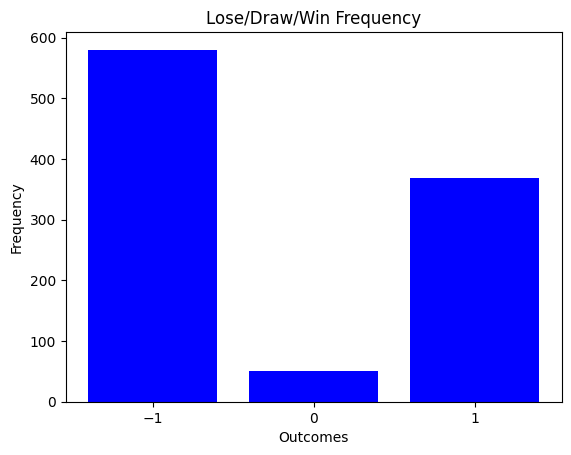

Likely Win State: {0: 0.6521739130434783, 1: -0.8878651685393258}
Likely Lose State: {0: -0.7303370786516854, 1: -0.297}


In [4]:
main()